# The BOTS (battle of the suburbs)

## Introduction / Business Problem

As a family who is looking to move to Sydney, Australia we want to find the right neighborhood to move into. Location location location is of key importance and currently living remotely makes it harder to do on the ground research. So we want to identify neighborhoods of interest on which to refine our search.

One of the factors determining location is proximity to good schools (or restaurants). The purpose of this project is to identify neighborhoods that may be prime candidates for moving to based on the number of schools or establishments nearby. 

This could also be relevant to business developers who are looking to find neighborhoods that are prime candidates for developing high density residential housing.

For our specific case, this is mainly a exploratory data analysis problem where we want to better understand the area and neighbourhoods to help us refine our search area. It may also be considered a clustering and / or recommendation system as an ideal solution may be to identify different clusters or zones of neighbourhoods and provide a list of recommendations as to which to investigate further. Our initial requirements are that the suburb should be not too far from the central business district, perhaps something like within 20-25 kilometers. It should be two or three bedroom home and additionally, we would want the median property price to not exceed 800,000 dollars. Of course these numbers may need to be revised based on what the market and data tells us...

## Data

### Initial Data - list of suburbs

The data that we will use can be data obtained from Wikipedia in terms of identifying the list of suburbs. 
We can then supplement with FourSquare data to find the number of and different category of establishments near by. 
The identification of restuarants and schools can be used as a way to score two different addresses or neighbourhoods when comparing the attractiveness of their relative locations. Plenty of web data is available in terms of auction results including dwelling type, number of bedrooms, bathrooms, car spaces. From this we may also be able to identify different distinct clusters of neighborhood.


As our starting data, we can scrape a list of suburbs from Wikipedia. Then this can be married with auction price data to get average sale prices and addresses of recent properties, which can then be used to identify proximity to the city, number of schools and number of restaurants. From this we can provide a recommeded list of suburbs as a short list from which to begin our property search!

Wikipedia link: https://www.domain.com.au/2-125-euston-road-alexandria-nsw-2015-2016142954


In [134]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

response = requests.get(r'https://en.wikipedia.org/wiki/List_of_Sydney_suburbs')
soup = BeautifulSoup(response.text, 'html.parser')

# Get suburbs of interest
suburbs = []
for tag in soup.findAll('a'):
    if 'New South Wales' in str(tag):
        suburb = tag.text
        suburbs.append(suburb)
        
# Keep unique list of suburbs
suburbs = list(set(suburbs))
suburbs.sort()

# Print count and some examples
print("We start with a list of {} suburbs".format(len(suburbs)))
print("Example entries: ")
print(suburbs[:5])

We start with a list of 693 suburbs
Example entries: 
['Abbotsbury', 'Abbotsford', 'Acacia Gardens', 'Agnes Banks', 'Airds']


Suburbs are geographical regions in Sydney that identify a neighbourhood. They tend to have different characteristics in terms of property supply and demand as well as property prices. We want to be able to reduce this list of 693 down to perhaps 10 or 20 recommended suburbs that meet other criteria as specified in the introduction and business problem.

### Auction Results - list of addresses

We can get auction results from somewhere like Domain. We can obtain a list of addresses and from these addresses find out more about their location (distance to Sydney, number of restaurants and number of schools.

Sample link to Auction Results: https://www.domain.com.au/auction-results/sydney/2020-05-02

From the summary page we get a list of auction results. Each of these results will have an address and further information such as number of beds, bathrooms and car spaces. We can use this information and query four square to determine the number of nearby schools or restaurants. 

Sample link to one specific auction property: https://www.domain.com.au/7-15-17-wyatt-avenue-burwood-nsw-2134-2016164763

This is a townhouse that sold last week for \$1.19 m and it's address is 7/15-17 Wyatt Avenue Burwood NSW 2134. 

In this specific instance that we take as an example we have the following data and this could potentially be scrapped to get it in bulk.

SOLD - $1,190,000
7/15-17 Wyatt Avenue Burwood NSW 2134

3Beds
1Bath
1Parking
234m²
Townhouse

### Four Square Data - list of schools and cafe

For each of the addresses of interest we can obtain the number of restaurant and schools nearby. In order to do so, we must first geocode the address to a set of GPS coordinates and then call the FourSquare api and pass it a search query such as the number of schools. The function query_four_square helps to form us a query and return the results for distances within 1000m. And we see the results of the queries for our example address when running a search query on school and cafe.

In [138]:
import os
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# we store this in environment variables so that we do not need to save it in the notebook
CLIENT_ID = os.environ['FOUR_SQUARE_CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = os.environ['FOUR_SQUARE_CLIENT_SECRET'] # your Foursquare Secret

def query_four_square(latitude, longitude, search_query = 'school', radius=1000):
    # This function is a convenience function that helps wraps the four square api
    VERSION = '20180604'
    LIMIT = 50
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    # print(results['meta'])
    # assign relevant part of JSON to venues
    venues = results['response']['venues']
    # print(" There are {} {}s nearby.".format(len(venues), search_query))
    dataframe = pd.json_normalize(venues)
    return dataframe

# In order to query Four square we need the GPS
address = '15-17 Wyatt Avenue Burwood NSW Australia'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The latitude and longitude of this property is: {}, {}".format(latitude, longitude))

The latitude and longitude of this property is: -33.8846186, 151.1041647


See the first few results when searching for schools for a given address

In [139]:
df = query_four_square(latitude, longitude, 'school')
df.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode
0,4f2c6451e4b0ecad92f73a32,Dorothy Cowie School of Dancing,"[{'id': '4bf58dd8d48988d13b941735', 'name': 'S...",v-1589041482,False,2a Fitzroy st,-33.883300,151.113920,"[{'label': 'display', 'lat': -33.8833, 'lng': ...",913,AU,Croydon,NSW,Australia,"[2a Fitzroy st, Croydon NSW, Australia]",NaN
1,4d8d01f3d00a6ea8a5f9974f,Enfield Public School,"[{'id': '4f4533804b9074f6e4fb0105', 'name': 'E...",v-1589041482,False,NaN,-33.888375,151.094429,"[{'label': 'display', 'lat': -33.8883749719673...",992,AU,NaN,NaN,Australia,[Australia],NaN
2,4f5aafba7716361189f2f4f6,Australian School of Yoga,"[{'id': '4bf58dd8d48988d102941735', 'name': 'Y...",v-1589041482,False,22 Church St,-33.881728,151.104369,"[{'label': 'display', 'lat': -33.8817281571954...",322,AU,Burwood,NSW,Australia,"[22 Church St, Burwood NSW 2134, Australia]",2134
3,505e6270e4b0f0e1a20e80dd,St. Vincent's Primary School,"[{'id': '4f4533804b9074f6e4fb0105', 'name': 'E...",v-1589041482,False,Charlotte St,-33.888191,151.104018,"[{'label': 'display', 'lat': -33.8881906047865...",397,AU,Ashfield,NSW,Australia,"[Charlotte St, Ashfield NSW, Australia]",NaN
4,4c6f1240b5a5236a00274c52,Burwood Public School,"[{'id': '4bf58dd8d48988d1a8941735', 'name': 'G...",v-1589041482,False,5 Conder St,-33.877198,151.099403,"[{'label': 'display', 'lat': -33.87719848, 'ln...",935,AU,Burwood,NSW,Australia,"[5 Conder St, Burwood NSW 2134, Australia]",2134


See the first few results when searching for schools for a given address

In [141]:
df = query_four_square(latitude, longitude, 'Restaurant')
df.head()

,id,name,categories,referralId,hasPerk,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.country,location.formattedAddress,location.address,location.postalCode,location.city,location.state
0,58c4938d5a5869779c78fbea,Royal Treasure Seafood Restaurant,"[{'id': '52af3a7c3cf9994f4e043bed', 'name': 'C...",v-1589041621,False,-33.878113,151.102505,"[{'label': 'display', 'lat': -33.8781133800789...",740,AU,Australia,[Australia],NaN,NaN,NaN,NaN
1,5d7215d985b85b0008c62987,Apandim Uyghur Restaurant 阿凡提,"[{'id': '52af3b913cf9994f4e043c06', 'name': 'X...",v-1589041621,False,-33.880350,151.103030,"[{'label': 'display', 'lat': -33.88035, 'lng':...",486,AU,Australia,"[189 Burwood Rd, Burwood NSW 2134, Australia]",189 Burwood Rd,2134,Burwood,NSW
2,5296f26f11d277dbb0e9c878,Hongyun Restaurant 鸿运食府,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1589041621,False,-33.880300,151.103028,"[{'label': 'display', 'lat': -33.8803002305661...",492,AU,Australia,"[246 Burwood Road, Burwood NSW 2134, Australia]",246 Burwood Road,2134,Burwood,NSW
3,4dc3c69fb0fb5556ccc588db,Korean Restaurant,"[{'id': '4bf58dd8d48988d113941735', 'name': 'K...",v-1589041621,False,-33.879252,151.103313,"[{'label': 'display', 'lat': -33.8792518162078...",602,AU,Australia,"[Burwood NSW, Australia]",NaN,NaN,Burwood,NSW
4,5240084c11d2ba03b61b9680,Chilli And Spicy Restaurant 一品湘,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",v-1589041621,False,-33.879216,151.103456,"[{'label': 'display', 'lat': -33.879216, 'lng'...",604,AU,Australia,"[175 Burwood Road, Burwood NSW 2134, Australia]",175 Burwood Road,2134,Burwood,NSW


This demonstrates the type of data we have (list of suburbs, list of addresses along with attributes and transaction prices. List of schools and restaurants nearby. Looking at the results make sense for one example property in that the results are also in the suburb of Burwood. We may need to do some EDA to determine the appropriate radius and supplement with further data in order to determine which schools / restaurants are good. Four square will also provide this data with premium accounts if needed.

## Methodology

The methodology will be as follows:
1. Preprocessing I: We scrape / retrieve list of auction results data from websites like domain.com.au (described above)
2. Preprocessing II: drop null values
3. Exploratory Data Analysis I: explore and filter out values that are not within the Sydney region (we can manually compare to the Wikipedia list of suburbs)
4. Classification I: Run K-means clustering to identifying different groups
5. Post Processing I: Filter out groups that are too far from Sydney
6. Post Processing II: For each group center, find the number of schools and cafes near by and look at the top 3 cluters
7. Post Processing III: Look at suburbs in the top 3 clusters and their average price and sort by ascending prices
8. Post Processing IV: Recommend the top 5 or 10 suburbs.


### Preprocessing of Data

#### Load Data

We load auction results data that we scrape and check to see the number of suburbs that we have

In [142]:
import pandas as pd

In [143]:
raw_df = pd.read_excel(r"D:\Downloads\property\master-auction-results-asof-2020-05-09.xlsx",
                  sheet_name='DomainAuctionResults')

In [144]:
raw_df.head()

,Date,Beds,Dwelling,PropertyKey,Suburb,PostCode,Address,AddressSuffix,AddressName,URL,...,Comment from Floor plan,Comment from photos,Comment on price,Size,Layout,Furnishing,Lighting,Strata (pq),Water (pq),Council (pq)
0,2019-07-27,0 beds,Studio,2042_Newtown_Rd_Enmore_12-14Unit10,Newtown,2042.0,10/12-14 Enmore Rd,Rd,Enmore,https://domain.com.au/property-profile/10-12-e...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-27,0 beds,Studio,2011_Elizabeth Bay_Rd_ElizabethBay_85-91Unit8b,Elizabeth Bay,2011.0,8b/85-91 Elizabeth Bay Rd,Rd,ElizabethBay,https://www.domain.com.au/8b-85-elizabeth-bay-...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-27,1 bed,House,2261_Killarney Vale_Rd_Robertson_55,Killarney Vale,2261.0,55 Robertson Rd,Rd,Robertson,https://domain.com.au/property-profile/55-robe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-07-27,1 bed,Unit,2022_Bondi Junction_St_Oxford_253Unit1303,Bondi Junction,2022.0,1303/253 Oxford St,St,Oxford,https://www.domain.com.au/1303-253-oxford-stre...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-07-27,1 bed,Unit,2071_Macquarie Park_Cr_Cottonwood_14Unit1,Macquarie Park,2071.0,1/14 Cottonwood Cr,Cr,Cottonwood,https://www.domain.com.au/23-2a-bruce-ave-kill...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
raw_df.shape

(11009, 45)

In [16]:
raw_df.columns

Index(['Date', 'Beds', 'Dwelling', 'PropertyKey', 'Suburb', 'PostCode',
       'Address', 'AddressSuffix', 'AddressName', 'URL', 'Status', 'Agent',
       'KPrice', 'Price', 'Council', 'Latitude', 'Longitude',
       'Distance to Sydney', 'Distance to Burwood', 'Distance to Yagoona',
       'bed', 'bth', 'car', 'intArea', 'Link', 'Shortlist1', 'Shortlist',
       'MBR L', 'MBR W', 'ENS', 'WIR', 'Floors', 'Lawn', 'Garage', 'Carpoort',
       'Comment from Floor plan', 'Comment from photos', 'Comment on price',
       'Size', 'Layout', 'Furnishing', 'Lighting', 'Strata (pq)', 'Water (pq)',
       'Council (pq)'],
      dtype='object')

In [17]:
len(raw_df['Suburb'].unique())

627

#### Filter Nulls

In [19]:
valid_df = raw_df[raw_df['Latitude'].notnull()]

In [20]:
valid_df.shape

(2118, 45)

In [21]:
len(valid_df['Suburb'].unique())

449

#### Add GPS Coordinates

In [22]:
from geopy import Nominatim
address = 'Sydney, New South Wales'

class GeocoderAdapter:
    def __init__(self, user_agent='sydney_explorer'):
        self.geolocator = Nominatim(user_agent=user_agent)
        
    def get_gps(self, suburb):
        try:
            address = suburb + ', New South Wales'
            geolocator = self.geolocator.geocode(address)
            address, gps = geolocator
            suburb = address.split(',')[0]
            latitude, longitude = gps
            return [suburb, latitude, longitude]
        except Exception as err:
            err_msg = '{} Error: {}'.format(suburb, err)
            return [err_msg, None, None]

In [23]:
geocoder = GeocoderAdapter('sydney_explorer')

In [24]:
sydney, latitude, longitude = geocoder.get_gps('Sydney')
sydney, latitude, longitude

('Sydney', -33.8548157, 151.2164539)

#### Visualize Data

In [26]:
from tqdm import tqdm
import time

In [28]:
import folium 

# create map of Sydney using latitude and longitude values
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=2, scrollWheelZoom=False)

# add markers to map
for suburb, lat, lng in tqdm(valid_df[['Suburb', 'Latitude', 'Longitude']].dropna().values):
    label = folium.Popup(suburb, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)
    
map_sydney

100%|███████████████████████████████████████████████████████████████████████████| 2118/2118 [00:00<00:00, 11324.22it/s]


We see a number of cases where the data seems inappropriate (e.g East Coast US) so let's find an appropriate threshold to filter these out

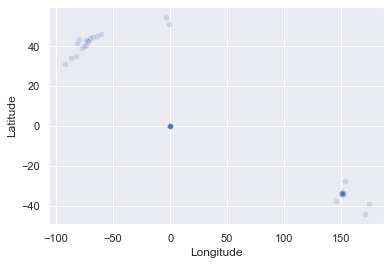

In [29]:
import seaborn as sns; 
sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="Longitude", y="Latitude", data=valid_df, alpha=0.2)

In [31]:
prefiltered_df = valid_df[(valid_df['Latitude'] < -33.5) & (valid_df['Latitude'] > -35) & (valid_df['Longitude'] > 150.6)]

In [32]:
prefiltered_df.shape

(1861, 45)

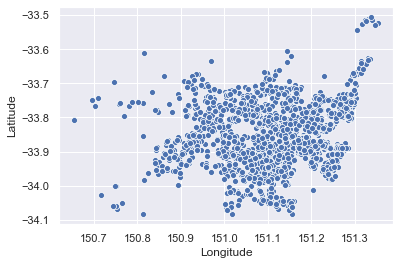

In [33]:
ax = sns.scatterplot(x="Longitude", y="Latitude", data=prefiltered_df)

In [34]:
import numpy as np
from sklearn.cluster import KMeans

In [35]:
def run_for_k(k, show_map=False, zoom=10):
    x = 'Longitude'
    y = 'Latitude'

    lat_long = np.column_stack((prefiltered_df[x], prefiltered_df[y]))
    kmeans = KMeans(n_clusters=k).fit(lat_long)

    prefiltered_data = prefiltered_df[[x, y]]
    prefiltered_array = prefiltered_data.to_numpy()

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.1     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = prefiltered_array[:, 0].min() - 1, prefiltered_array[:, 0].max() + 1
    y_min, y_max = prefiltered_array[:, 1].min() - 1, prefiltered_array[:, 1].max() + 1

    print('Boundaries are:')
    print(x_min, x_max, y_min, y_max)

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Pastel2, aspect='auto', origin='lower')

    centroids = kmeans.cluster_centers_

    plt.scatter(centroids[:, 0], 
                centroids[:, 1],
    #             marker='x', 
                s=50, 
                linewidths=3,
                color='orange', 
                alpha=0.5,
                zorder=10,
               )

    ax = sns.scatterplot(x=x, y=y, data=prefiltered_data)
    ax.set_xlabel(x.replace('_', ' ').title(), fontsize=16)

    plt.show();

    # create map of Sydney using latitude and longitude values
    map_sydney = folium.Map(location=[latitude, longitude], zoom_start=zoom, scrollWheelZoom=False)

    # add markers to map
    for centroid, (lng, lat) in tqdm(enumerate(kmeans.cluster_centers_)):
        label = folium.Popup('Centroid {}'.format(centroid), parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_sydney)

    if show_map:
        display(map_sydney)
        
    return [[k_means.predict(centroid.reshape(1, -1))[0], centroid] for centroid in centroids]

In [40]:
def format_dataframe_for_model(df, x1='Longitude', x2='Latitude'):
    return np.column_stack((df[x1], df[x2]))

In [37]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

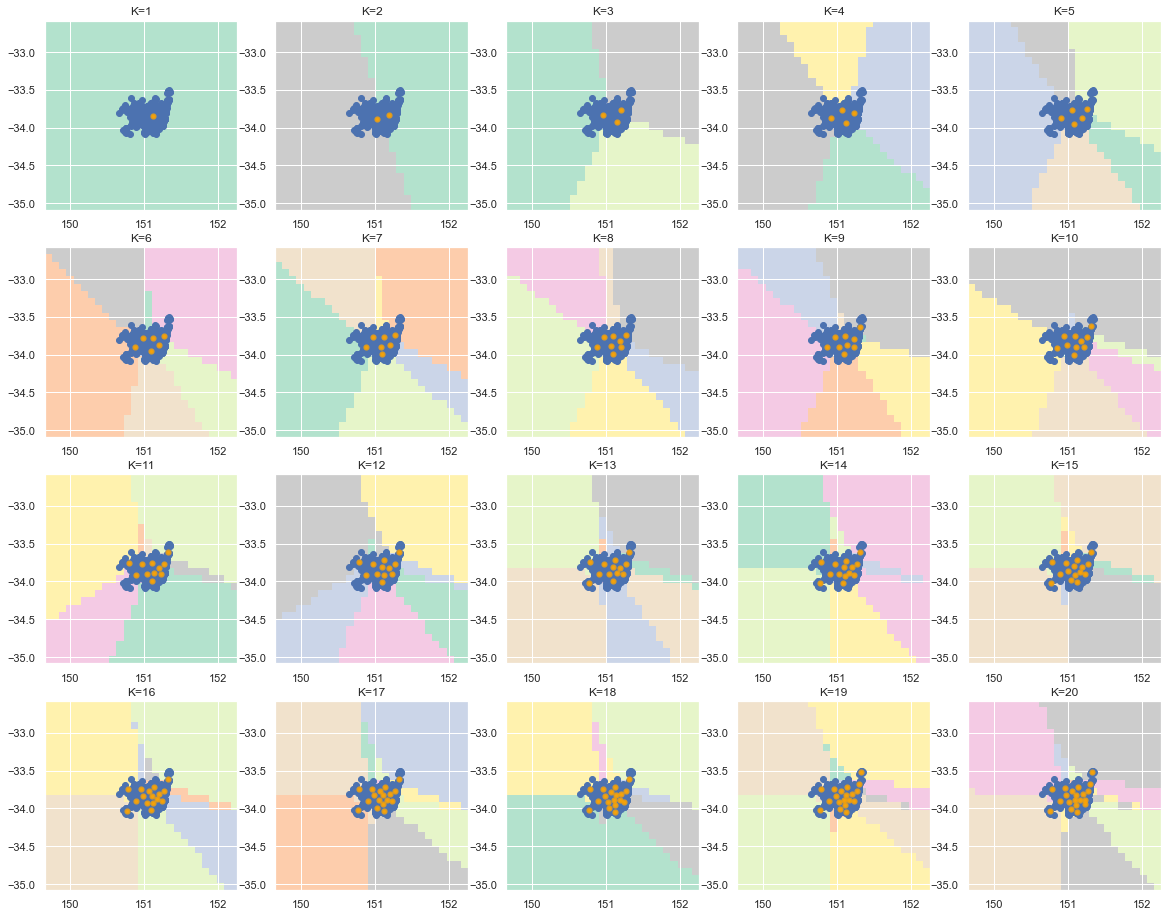

In [42]:
num_cols = 5
num_rows = 4

fig = plt.figure(figsize=(4 * num_cols, 4 * num_rows))
grid = plt.GridSpec(num_rows, num_cols, hspace=0.2, wspace=0.2)

x1 = 'Longitude'
x2 = 'Latitude'

X = format_dataframe_for_model(prefiltered_df, x1, x2)

XY = prefiltered_df[[x1, x2]].to_numpy()

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.1     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = XY[:, 0].min() - 1, XY[:, 0].max() + 1
y_min, y_max = XY[:, 1].min() - 1, XY[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

X_grid = np.c_[xx.ravel(), yy.ravel()]

for n_col in range(num_cols):
    for n_row in range(num_rows):
        main_ax = fig.add_subplot(grid[n_row, n_col])
        k = n_row * num_cols + n_col + 1
        main_ax.set_title('K={}'.format(k))
        
        k_means = KMeans(n_clusters=k).fit(X)
        Z = k_means.predict(X_grid)
        Z = Z.reshape(xx.shape)
        
        main_ax.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=plt.cm.Pastel2, aspect='auto', origin='lower')
        main_ax.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], s=10, linewidths=3,color='orange', alpha=0.8, zorder=10)
        main_ax.scatter(x=x1, y=x2, data=prefiltered_df)
       
    plt.plot();

Boundaries are:
149.654252499999 152.3536163 -35.0838664 -32.5047425


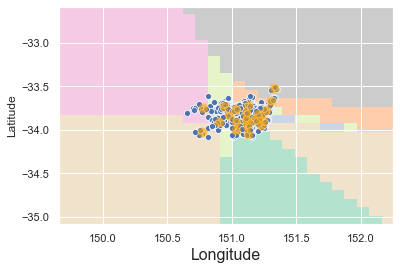

20it [00:00, 9791.77it/s]


[[0, array([151.20012007, -33.81365975])],
 [1, array([150.97456826, -33.82417517])],
 [16, array([151.12377399, -34.0463371 ])],
 [6, array([151.10650926, -33.88565384])],
 [8, array([151.30430642, -33.67235181])],
 [10, array([151.12661233, -33.71710897])],
 [2, array([151.17085922, -33.885318  ])],
 [18, array([151.23807719, -33.89009692])],
 [4, array([150.89857069, -33.90583496])],
 [9, array([150.7743226 , -33.75198536])],
 [12, array([151.26717101, -33.76829767])],
 [13, array([151.03585935, -34.00616016])],
 [7, array([150.94214418, -33.72995348])],
 [19, array([151.02846209, -33.90765233])],
 [5, array([151.03514962, -33.76214223])],
 [11, array([151.23010514, -33.94303821])],
 [14, array([150.76722812, -34.02664423])],
 [17, array([151.33100217, -33.52034542])],
 [3, array([151.11529676, -33.95766547])],
 [15, array([151.10808608, -33.80536039])]]

In [44]:
centroids = run_for_k(20, show_map=True, zoom=11)
centroids

In [45]:
from geopy.distance import geodesic

In [46]:
sydney_city_gps = geolocator.geocode("Central Station NSW Sydney")[-1]
sydney_lat, sydney_lng = sydney_city_gps

In [47]:
def dist_to_syd(lat, lng):
    km_to_syd = geodesic((lat, lng), sydney_city_gps).km
    return [km_to_syd <20, km_to_syd]

In [49]:
centroid_dist_data = [[class_num, lat, lng] + dist_to_syd(lat, lng) for class_num, (lng, lat) in centroids]
centroid_dist_df = pd.DataFrame(centroid_dist_data, columns=['Class', 'Latitude', 'Longitude', 'Within20k', 'DistanceToSydney'])
centroid_dist_df

,Class,Latitude,Longitude,Within20k,DistanceToSydney
0,0,-33.813660,151.200120,True,7.335934
1,1,-33.824175,150.974568,False,22.575785
2,16,-34.046337,151.123774,False,20.142188
3,6,-33.885654,151.106509,True,9.542437
4,8,-33.672352,151.304306,False,24.585360
5,10,-33.717109,151.126612,True,19.559195
6,2,-33.885318,151.170859,True,3.624692
7,18,-33.890097,151.238077,True,2.910386
8,4,-33.905835,150.898571,False,28.899876
9,9,-33.751985,150.774323,False,42.684600


In [154]:
map_sydney = folium.Map(location=[sydney_lat, sydney_lng], zoom_start=10, scrollWheelZoom=False)

# add markers to map
for centroid, (class_num, lat, lng, within20k, dist) in tqdm(enumerate(centroid_dist_data)):
    label = folium.Popup('Centroid {}'.format(class_num), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10 if class_num in (2, 10, 6) else 5,
        popup=label,
        color='blue' if within20k else 'red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sydney)
    
    if within20k:
        print("Cluster {} ({}, {}) is within 20km of Sydney CBD".format(class_num, lat, lng))

display(map_sydney)

20it [00:00, 6732.43it/s]

Cluster 0 (-33.813659752368416, 151.20012006754226) is within 20km of Sydney CBD
Cluster 6 (-33.885653838333326, 151.10650925636858) is within 20km of Sydney CBD
Cluster 10 (-33.71710897252136, 151.12661232814526) is within 20km of Sydney CBD
Cluster 2 (-33.885317999821154, 151.17085921764135) is within 20km of Sydney CBD
Cluster 18 (-33.89009692038787, 151.2380771881357) is within 20km of Sydney CBD
Cluster 12 (-33.76829767452229, 151.26717100764324) is within 20km of Sydney CBD
Cluster 19 (-33.90765233333333, 151.02846209047615) is within 20km of Sydney CBD
Cluster 11 (-33.943038210606055, 151.23010513503138) is within 20km of Sydney CBD
Cluster 3 (-33.95766547442717, 151.11529676001894) is within 20km of Sydney CBD
Cluster 15 (-33.805360390625, 151.10808608159087) is within 20km of Sydney CBD


In [52]:
four_square_data = [[class_num, lat, long, within20k, distance, len(query_four_square(lat, long, 'school')), len(query_four_square(lat, long, 'cafe'))] for class_num, lat, long, within20k, distance in centroid_dist_data]

In [99]:
four_square_df = pd.DataFrame(four_square_data, columns=['Class', 'Latitude', 'Longitude', 'Within20km', 'Distance', 'Schools', 'Cafes'])
four_square_df.columns = ['Centroid' + col for col in four_square_df.columns]
four_square_df.rename(columns={'CentroidClass': 'Class'}, inplace=True)
four_square_df.sort_values(by=['CentroidWithin20km', 'CentroidSchools'], ascending=False, inplace=True)
four_square_df

,Class,CentroidLatitude,CentroidLongitude,CentroidWithin20km,CentroidDistance,CentroidSchools,CentroidCafes
6,2,-33.885318,151.170859,True,3.624692,19,47
5,10,-33.717109,151.126612,True,19.559195,13,5
3,6,-33.885654,151.106509,True,9.542437,12,41
0,0,-33.813660,151.200120,True,7.335934,9,50
7,18,-33.890097,151.238077,True,2.910386,9,50
15,11,-33.943038,151.230105,True,7.320358,7,17
10,12,-33.768298,151.267171,True,13.428934,6,27
13,19,-33.907652,151.028462,True,17.026894,4,17
18,3,-33.957665,151.115297,True,12.294884,4,3
19,15,-33.805360,151.108086,True,12.459454,4,15


In [100]:
top_three_centroids = four_square_df['Class'].head(3).values
top_three_centroids

array([ 2, 10,  6], dtype=int64)

In [101]:
four_square_df['Top3Centroids'] = four_square_df['Class'].isin(top_three_centroids)

In [102]:
kmeans_in_df = prefiltered_df[['PropertyKey', 'Latitude', 'Longitude']].drop_duplicates()
kmeans_in_df

,PropertyKey,Latitude,Longitude
8891,2230_Woolooware_Rd_Dolans_47B,-34.047173,151.137127
8893,2223_Mortdale_St_Kemp_39,-33.967011,151.073993
8894,2026_Bondi Beach_Pde_Campbell_102-106/1,-33.894544,151.273176
8895,2039_Rozelle_St_Terry_41/303,-33.860785,151.167789
8896,2017_Waterloo_Av_Archibald_9/113,-33.901593,151.210304
...,...,...,...
11004,2174_Edmondson Park_Dr_Kimberley_19,-33.954821,150.843820
11005,2219_Sandringham_Av_Clareville_110,-33.998748,151.139256
11006,2074_Turramurra_Rd_BobbinHead_90,-33.729890,151.138157
11007,2125_West Pennant Hills_Av_Riley_14,-33.756300,151.038372


In [103]:
def get_class(x):
    return k_means.predict(np.array([x[1], x[0]]).reshape(1, -1))[0]

In [104]:
kmeans_in_df['Class'] = kmeans_in_df[['Latitude', 'Longitude']].apply(get_class, axis=1)

In [105]:
kmeans_in_df.head()

,PropertyKey,Latitude,Longitude,Class
8891,2230_Woolooware_Rd_Dolans_47B,-34.047173,151.137127,16
8893,2223_Mortdale_St_Kemp_39,-33.967011,151.073993,3
8894,2026_Bondi Beach_Pde_Campbell_102-106/1,-33.894544,151.273176,18
8895,2039_Rozelle_St_Terry_41/303,-33.860785,151.167789,2
8896,2017_Waterloo_Av_Archibald_9/113,-33.901593,151.210304,18


In [108]:
df_out = pd.merge(kmeans_in_df, four_square_df, how='left')
df_out

,PropertyKey,Latitude,Longitude,Class,CentroidLatitude,CentroidLongitude,CentroidWithin20km,CentroidDistance,CentroidSchools,CentroidCafes,Top3Centroids
0,2230_Woolooware_Rd_Dolans_47B,-34.047173,151.137127,16,-34.046337,151.123774,False,20.142188,4,8,False
1,2223_Mortdale_St_Kemp_39,-33.967011,151.073993,3,-33.957665,151.115297,True,12.294884,4,3,False
2,2026_Bondi Beach_Pde_Campbell_102-106/1,-33.894544,151.273176,18,-33.890097,151.238077,True,2.910386,9,50,False
3,2039_Rozelle_St_Terry_41/303,-33.860785,151.167789,2,-33.885318,151.170859,True,3.624692,19,47,True
4,2017_Waterloo_Av_Archibald_9/113,-33.901593,151.210304,18,-33.890097,151.238077,True,2.910386,9,50,False
...,...,...,...,...,...,...,...,...,...,...,...
1820,2174_Edmondson Park_Dr_Kimberley_19,-33.954821,150.843820,4,-33.905835,150.898571,False,28.899876,4,2,False
1821,2219_Sandringham_Av_Clareville_110,-33.998748,151.139256,16,-34.046337,151.123774,False,20.142188,4,8,False
1822,2074_Turramurra_Rd_BobbinHead_90,-33.729890,151.138157,10,-33.717109,151.126612,True,19.559195,13,5,True
1823,2125_West Pennant Hills_Av_Riley_14,-33.756300,151.038372,5,-33.762142,151.035150,False,20.716510,2,5,False


In [109]:
df_out[df_out['Top3Centroids']]

,PropertyKey,Latitude,Longitude,Class,CentroidLatitude,CentroidLongitude,CentroidWithin20km,CentroidDistance,CentroidSchools,CentroidCafes,Top3Centroids
3,2039_Rozelle_St_Terry_41/303,-33.860785,151.167789,2,-33.885318,151.170859,True,3.624692,19,47,True
6,2194_Campsie_St_Campsie_71/4,-33.911473,151.096744,6,-33.885654,151.106509,True,9.542437,12,41,True
7,2196_Roselands_Av_Payten_98/108,-33.931903,151.071157,6,-33.885654,151.106509,True,9.542437,12,41,True
13,2037_Forest Lodge_Cl_Cullen_1/G.02,-33.878246,151.178273,2,-33.885318,151.170859,True,3.624692,19,47,True
24,2009_Pyrmont_St_Jones_280/805,-33.869427,151.191466,2,-33.885318,151.170859,True,3.624692,19,47,True
...,...,...,...,...,...,...,...,...,...,...,...
1794,2203_Dulwich Hill_Gr_Canonbury_29A,-33.907245,151.143518,2,-33.885318,151.170859,True,3.624692,19,47,True
1803,2204_Marrickville_St_Roseby_33,-33.919374,151.147506,2,-33.885318,151.170859,True,3.624692,19,47,True
1805,2042_Newtown_St_Watkin_73,-33.896423,151.183980,2,-33.885318,151.170859,True,3.624692,19,47,True
1806,2137_Concord_Rd_Burwood_143,-33.860966,151.110373,6,-33.885654,151.106509,True,9.542437,12,41,True


In [112]:
df_final = pd.merge(prefiltered_df, df_out, on=['PropertyKey', 'Latitude', 'Longitude'], how='left')
df_final

,Date,Beds,Dwelling,PropertyKey,Suburb,PostCode,Address,AddressSuffix,AddressName,URL,...,Water (pq),Council (pq),Class,CentroidLatitude,CentroidLongitude,CentroidWithin20km,CentroidDistance,CentroidSchools,CentroidCafes,Top3Centroids
0,2020-03-07,0 beds,House,2230_Woolooware_Rd_Dolans_47B,Woolooware,2230.0,47B Dolans Rd,Rd,Dolans,https://domain.com.au/property-profile/47b-dol...,...,NaN,NaN,16,-34.046337,151.123774,False,20.142188,4,8,False
1,2020-03-07,1 bed,House,2223_Mortdale_St_Kemp_39,Mortdale,2223.0,39 Kemp St,St,Kemp,https://www.domain.com.au/39-kemp-street-mortd...,...,NaN,NaN,3,-33.957665,151.115297,True,12.294884,4,3,False
2,2020-03-07,1 bed,Unit,2026_Bondi Beach_Pde_Campbell_102-106/1,Bondi Beach,2026.0,1/102-106 Campbell Pde,Pde,Campbell,https://www.domain.com.au/1-102-106-campbell-p...,...,NaN,NaN,18,-33.890097,151.238077,True,2.910386,9,50,False
3,2020-03-07,1 bed,Unit,2039_Rozelle_St_Terry_41/303,Rozelle,2039.0,303/41 Terry St,St,Terry,https://domain.com.au/property-profile/303-41-...,...,NaN,NaN,2,-33.885318,151.170859,True,3.624692,19,47,True
4,2020-03-07,1 bed,Unit,2017_Waterloo_Av_Archibald_9/113,Waterloo,2017.0,113/9 Archibald Av,Av,Archibald,https://www.domain.com.au/113-9-archibald-aven...,...,NaN,NaN,18,-33.890097,151.238077,True,2.910386,9,50,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,2020-05-02,5 beds,House,2174_Edmondson Park_Dr_Kimberley_19,Edmondson Park,2174.0,19 Kimberley Dr,Dr,Kimberley,https://www.domain.com.au/19-kimberley-drive-e...,...,NaN,NaN,4,-33.905835,150.898571,False,28.899876,4,2,False
1857,2020-05-02,5 beds,House,2219_Sandringham_Av_Clareville_110,Sandringham,2219.0,110 Clareville Av,Av,Clareville,https://www.domain.com.au/110-clareville-avenu...,...,NaN,NaN,16,-34.046337,151.123774,False,20.142188,4,8,False
1858,2020-05-02,5 beds,House,2074_Turramurra_Rd_BobbinHead_90,Turramurra,2074.0,90 Bobbin Head Rd,Rd,BobbinHead,https://www.domain.com.au/90-bobbin-head-road-...,...,NaN,NaN,10,-33.717109,151.126612,True,19.559195,13,5,True
1859,2020-05-02,5 beds,House,2125_West Pennant Hills_Av_Riley_14,West Pennant Hills,2125.0,14 Riley Av,Av,Riley,https://www.domain.com.au/14-riley-avenue-west...,...,NaN,NaN,5,-33.762142,151.035150,False,20.716510,2,5,False


In [128]:
top_suburbs = list(pd.DataFrame(df_final.loc[df_final['Top3Centroids'], 'Suburb'].value_counts()).head(10).index)
top_suburbs

['Strathfield',
 'Ashfield',
 'Newtown',
 'Balmain',
 'Camperdown',
 'Marrickville',
 'Erskineville',
 'St Ives',
 'Turramurra',
 'Stanmore']

In [124]:
df_final.columns

Index(['Date', 'Beds', 'Dwelling', 'PropertyKey', 'Suburb', 'PostCode',
       'Address', 'AddressSuffix', 'AddressName', 'URL', 'Status', 'Agent',
       'KPrice', 'Price', 'Council', 'Latitude', 'Longitude',
       'Distance to Sydney', 'Distance to Burwood', 'Distance to Yagoona',
       'bed', 'bth', 'car', 'intArea', 'Link', 'Shortlist1', 'Shortlist',
       'MBR L', 'MBR W', 'ENS', 'WIR', 'Floors', 'Lawn', 'Garage', 'Carpoort',
       'Comment from Floor plan', 'Comment from photos', 'Comment on price',
       'Size', 'Layout', 'Furnishing', 'Lighting', 'Strata (pq)', 'Water (pq)',
       'Council (pq)', 'Class', 'CentroidLatitude', 'CentroidLongitude',
       'CentroidWithin20km', 'CentroidDistance', 'CentroidSchools',
       'CentroidCafes', 'Top3Centroids'],
      dtype='object')

In [146]:
df_final[df_final['Suburb'].isin(top_suburbs)].groupby('Suburb').mean().sort_values('KPrice', ascending=True)

,PostCode,KPrice,Latitude,Longitude,Distance to Sydney,Distance to Burwood,Distance to Yagoona,car,intArea,Shortlist1,...,Water (pq),Council (pq),Class,CentroidLatitude,CentroidLongitude,CentroidWithin20km,CentroidDistance,CentroidSchools,CentroidCafes,Top3Centroids
Suburb,,,,,,,,,,,,,,,,,,,,,
St Ives,2075.0,652.222222,-33.726897,151.167501,17.357273,17.717273,24.635455,1.833333,NaN,False,...,NaN,NaN,10.0,-33.717109,151.126612,True,19.559195,13.0,5.0,True
Balmain,2041.0,815.384615,-33.859513,151.180362,3.490000,6.930667,16.012000,1.000000,124.000000,True,...,NaN,NaN,2.0,-33.885318,151.170859,True,3.624692,19.0,47.0,True
Stanmore,2048.0,902.909091,-33.891271,151.167791,4.080909,5.595455,13.970909,1.428571,99.000000,False,...,NaN,NaN,2.0,-33.885318,151.170859,True,3.624692,19.0,47.0,True
Ashfield,2131.0,1012.882353,-33.886931,151.127924,7.595556,2.016667,10.461667,1.166667,147.000000,False,...,NaN,NaN,4.0,-33.885486,151.138684,True,6.583564,15.5,44.0,True
Erskineville,2043.0,1051.363636,-33.903502,151.184830,3.516364,7.516364,15.399091,0.750000,121.500000,False,...,NaN,NaN,2.0,-33.885318,151.170859,True,3.624692,19.0,47.0,True
Marrickville,2204.0,1192.122500,-33.911405,151.151615,6.427143,5.372857,12.311429,1.250000,105.666667,True,...,NaN,NaN,2.0,-33.885318,151.170859,True,3.624692,19.0,47.0,True
Camperdown,2050.0,1241.339286,-33.888191,151.175908,3.266429,6.269286,14.769286,1.500000,59.000000,False,...,NaN,NaN,2.0,-33.885318,151.170859,True,3.624692,19.0,47.0,True
Newtown,2042.0,1410.125000,-33.900790,151.176798,3.862941,6.723529,14.681176,0.600000,234.000000,True,...,NaN,NaN,2.0,-33.885318,151.170859,True,3.624692,19.0,47.0,True
Strathfield,2135.0,2053.833333,-33.879597,151.082644,11.753810,2.606667,6.915238,2.555556,NaN,False,...,NaN,NaN,6.0,-33.885654,151.106509,True,9.542437,12.0,41.0,True


## Results

Based on the above analysis, we can recommend exploring the following suburbs: 

1. St Ives
2. Balmain
3. Stanmore
4. Ashfield
5. Erskineville
6. Marrickville
7. Camperdown
8. Newton
9. Strathfield
10. Turramurra

There are suburbs which all are not too far from the Sydney nor where existing family live and it boasts a high number of schools and cafes. This helps to provide a way to narrow down suburbs sytematically and helps to prevent the overlooking of potential good candidate subjects. For example, we see that the median price for a home is St Ives is approximately 650k vs in Strathfield which is just over 2 million. There will indeed be other explanatory features which explain such differences (e.g number of bedrooms, internal area, landsize etc) but at least we have a high level starting point on which we can narrow our search.

## Discussion

A number of parameters were assumed in this case. Some limitations or potential improvements include:

- Looking at a longer dated period of history or auction results

- Doing some analysis on optimal number of K for the k-means clustering (e.g elbow test)

- Tweaking various levels of distance when using the four square api to determine the number of close schools and restaurants

- Exploring the user ratings or scores of schools / restaurants

- Taking into consideration the different dwelling types (e.g house with land, town house vs apartment), internal area size, number of bed and bathrooms etc

Some observations noted include:

- Auction results go through different periods of activity, some periods are a lot mroe quiet whislt other periods have high demand, this may affect the price

- The four square API does not always seem to return all results and it may be worth exploring different keywords or combining with other data sources

- We limit the use of our Four Square API by only making calls the each centroid as we take it as representative of the neighborhood but we could also tweak the parameters and run for a more specific address to compare different streets within a given neighborhood.

## Conclusion

In terms of using data to provide recommendations based on distance to CBD, schools and cafes within a certain price point, the following report provides a list of 10 recommended suburbs to go on a short list to narrow down a property purchase search. A number of the recommendations make sense to me and were suburbs that I was already considering. However, a number of other suburbs including the top recommendation of St Ives is something that I have not considered and could be worth exploring and it may represent better value compared to other more popular or high demand suburbs. 